## Calculate ion richness and Shannon diversity

load libraries

In [1]:
library(vegan)
library(ggplot2)
library(rstatix)
library(ggpubr)
library(ggbeeswarm)
library(multcompView)
library(viridis)
library(dplyr)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Loading required package: magrittr

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




load functions

In [3]:
generate_label_df <- function(TUKEY, variable){
 
     # Extract labels and factor levels from Tukey post-hoc 
     Tukey.levels <- TUKEY[[variable]][,4]
     Tukey.labels <- data.frame(multcompLetters(Tukey.levels)['Letters'])
     
     #I need to put the labels in the same order as in the boxplot :
     Tukey.labels$treatment=rownames(Tukey.labels)
     Tukey.labels=Tukey.labels[order(Tukey.labels$treatment) , ]
     return(Tukey.labels)
     }

load feature table

In [5]:
ft <- read.csv('../featuretable_blankfiltered.tsv', sep = '\t', check.names = F)

In [7]:
ft <- as.data.frame(t(ft))
colnames(ft) <- ft[1,]
ft <- ft[-1,]

calculate mass spectral feature richness and Shannon Index

In [9]:
shannon <- diversity(ft, index = "shannon", MARGIN = 1, base = exp(1))
sprichness <- specnumber(ft, MARGIN = 1)

load metadata

In [10]:
md <- read.table('../metadata.tsv', sep = '\t', header = T)

In [11]:
md <- md[which(md$filename %in% rownames(ft)),]

In [13]:
md <- md[match(rownames(ft),md$filename),]
identical(as.character(md$filename),as.character(rownames(ft)))

[1] TRUE

In [14]:
md$shannon <- shannon
md$sprichness <- sprichness

In [16]:
md$ATTRIBUTE_Gestationsalder <- as.factor(md$ATTRIBUTE_Gestationsalder)
md$Term_categorical <- cut(as.numeric(as.character(md$ATTRIBUTE_Gestationsalder)), labels = c('very preterm', 'near term', 'term', 'late term'), breaks = c(27, 32, 36, 40, 42))
md$Term_binary <- cut(as.numeric(as.character(md$ATTRIBUTE_Gestationsalder)), labels = c('preterm', 'term'), breaks = c(27, 36, 42))

# Ion richness

## By prematurity category

In [17]:
comparisons_Term <- list( c("very preterm", "near term"), 
                       c("very preterm", "term"), 
                       c("very preterm", "late term"),
                      c('near term', 'term'),
                      c('near term', 'late term'),
                      c('term', 'late term'))

In [18]:
stat.richness.term_categorical <- aov(sprichness ~ Term_categorical, data = md) %>%
  TukeyHSD()
labels.richness.term_categorical <- generate_label_df(stat.richness.term_categorical, "Term_categorical")
colnames(labels.richness.term_categorical)[which(colnames(labels.richness.term_categorical) == 'treatment')] <- 'Term_categorical'
labels.richness.term_categorical.full <- md %>%
     group_by(Term_categorical) %>%
     summarize(ypos = max(sprichness) + 100 ) %>%
     inner_join(., labels.richness.term_categorical)

Joining, by = "Term_categorical"
Warning message:
“Column `Term_categorical` joining factor and character vector, coercing into character vector”


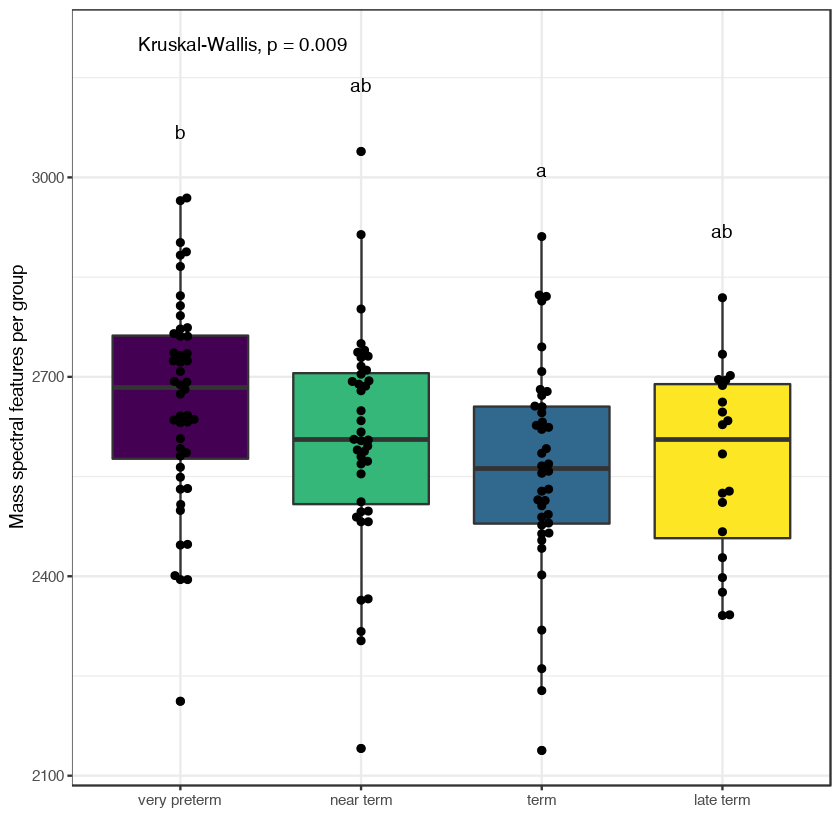

In [19]:
ggplot(md, aes(x=Term_categorical, y=sprichness, fill=Term_categorical)) + 
  xlab('') +
  ylab('Mass spectral features per group') +
  stat_compare_means(label.y = 3200, label.x = 1) +
  geom_text(data=labels.richness.term_categorical.full, aes(label=Letters), y = labels.richness.term_categorical.full$ypos) +  
  theme_bw() +
  theme(legend.position = "none") +
  geom_boxplot() +
  scale_fill_viridis(discrete = TRUE, direction = -1) +
  geom_beeswarm()

## By gestational age

In [20]:
GAcomb <- combn(unique(as.character(md$ATTRIBUTE_Gestationsalder)), 2)
comparisons_GA <- split(GAcomb, rep(1:ncol(GAcomb), each = nrow(GAcomb)))

In [22]:
stat.richness.GA <- aov(sprichness ~ ATTRIBUTE_Gestationsalder, data = md) %>%
  TukeyHSD()
labels.richness.GA <- generate_label_df(stat.richness.GA, "ATTRIBUTE_Gestationsalder")
colnames(labels.richness.GA)[which(colnames(labels.richness.GA) == 'treatment')] <- 'ATTRIBUTE_Gestationsalder'
labels.richness.GA.full <- md %>%
     group_by(ATTRIBUTE_Gestationsalder) %>%
     summarize(ypos = max(sprichness) + 100 ) %>%
     inner_join(., labels.richness.GA)

Joining, by = "ATTRIBUTE_Gestationsalder"
Warning message:
“Column `ATTRIBUTE_Gestationsalder` joining factor and character vector, coercing into character vector”


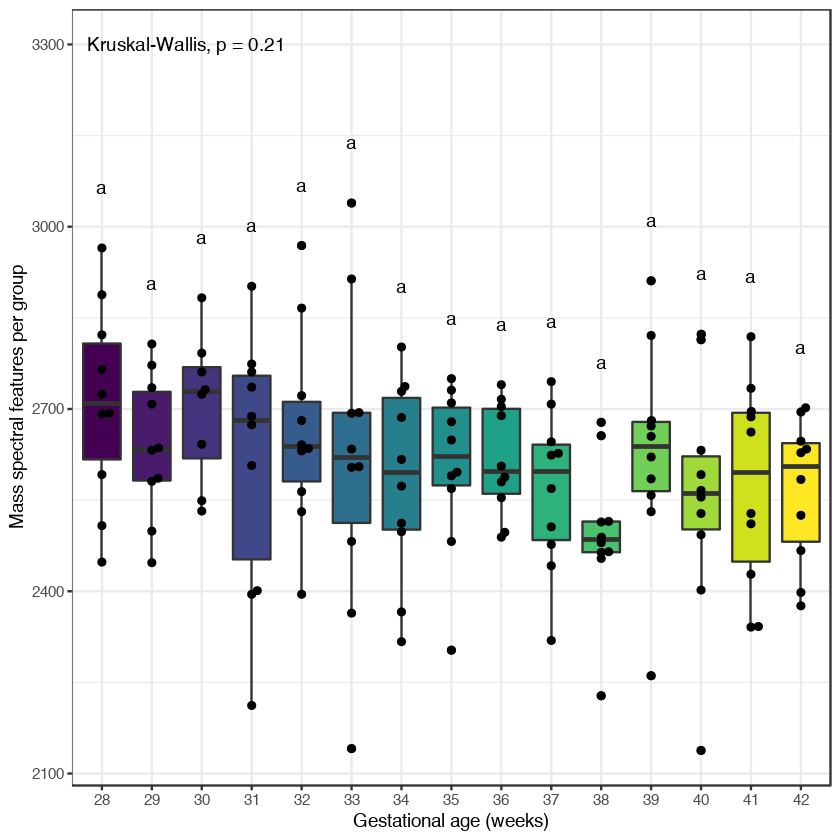

In [23]:
ggplot(md, aes(x=ATTRIBUTE_Gestationsalder, y=sprichness, fill=ATTRIBUTE_Gestationsalder)) + 
  xlab('Gestational age (weeks)') +
  ylab('Mass spectral features per group') +
  geom_text(data=labels.richness.GA.full, aes(label=Letters), y = labels.richness.GA.full$ypos) +
  stat_compare_means(label.y = 3300, label.x = 1.5) +  
  theme_bw() +
  theme(legend.position = "none") +
  geom_boxplot() +
  scale_fill_viridis(discrete = TRUE) +
  geom_beeswarm()

In [24]:
cor.test(as.numeric(as.character(md$ATTRIBUTE_Gestationsalder)), scale(md$sprichness)[,1], method = 'kendall')


	Kendall's rank correlation tau

data:  as.numeric(as.character(md$ATTRIBUTE_Gestationsalder)) and scale(md$sprichness)[, 1]
z = -3.2079, p-value = 0.001337
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.1831627 


# Shannon diversity

## By prematurity category

In [30]:
stat.diversity.term_categorical <- aov(shannon ~ Term_categorical, data = md) %>%
  TukeyHSD()
labels.diversity.term_categorical <- generate_label_df(stat.diversity.term_categorical, "Term_categorical")
colnames(labels.diversity.term_categorical)[which(colnames(labels.diversity.term_categorical) == 'treatment')] <- 'Term_categorical'
labels.diversity.term_categorical.full <- md %>%
     group_by(Term_categorical) %>%
     summarize(ypos = max(shannon) + 0.1 ) %>%
     inner_join(., labels.diversity.term_categorical)

Joining, by = "Term_categorical"
Warning message:
“Column `Term_categorical` joining factor and character vector, coercing into character vector”


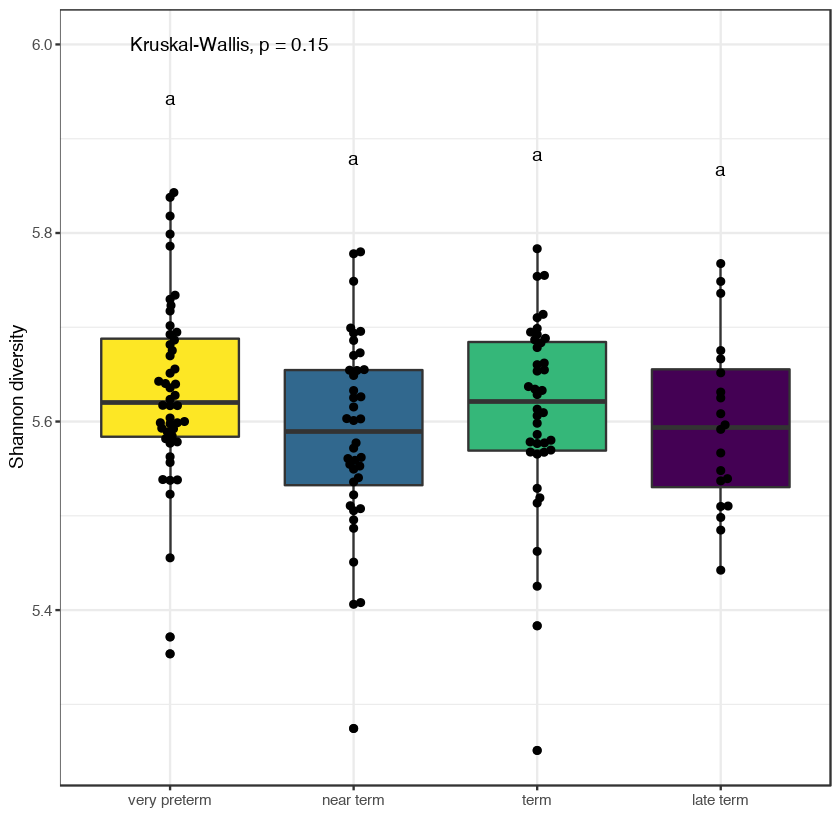

In [31]:
ggplot(md, aes(x=Term_categorical, y=shannon, fill=Term_categorical)) + 
  xlab('') +
  ylab('Shannon diversity') +
  stat_compare_means(label.y = 6.0, label.x = 1) +
  geom_text(data=labels.diversity.term_categorical.full, aes(label=Letters), y = labels.diversity.term_categorical.full$ypos) +  
  theme_bw() +
  theme(legend.position = "none") +
  geom_boxplot() +
  scale_fill_viridis(discrete = TRUE, direction = 1) +
  geom_beeswarm()